# Blind Prediction and Performance Estimation on Smartphone Sensor Signals
**Author: Paul Roode**

**_NOTE: The computation time of this Jupyter Notebook is ~1 hour on a Google Colab GPU accelerator. Most of this time is allocated to fitting grid and randomized search instances on training data (especially for optimizing an XGBoost model) and assessing ensemble classifier performance via cross-validation._**

## Objectives

1. Optimize and combine multiple different ML models into an ensemble that maximizes blind prediction accuracy and precision on unlabeled smartphone sensor signal data.

2. Compute ensemble KPIs via cross-validation, a confusion matrix, and precision-recall curves.

## About the Dataset
Available for download [here](https://github.com/jrgreen7/SYSC4906/releases/download/Assignment3/SYSC4415W23_A3_dataset.zip). Each data sample corresponds to a 7.5-s smartphone sensor signal resampled at 100 Hz. Over 4000 features were extracted from the samples using the time-series feature extraction library `tsfresh`.

The `train` and `test` folders contain 1621 and 287 samples, respectively. Each sample was assigned an integer ID randomly. The folders contain:
1. A subfolder named `signals` which contains processed signals in CSV format. Each file follows the naming convention `<sample_id>.csv` and contains the time-series data for 9 signals: g-force *gF*, acceleration *a*, and displacement *w* along the *x*-, *y*-, and *z*-axes.
2. A subfolder named `images` which contains images of 6 plotted sensor signals (g-force and accelerometer signals along each dimension). Each file is a 255$\times$255-px image named `<sample_id>.png`. The images enable the use of 2-D CNNs and can be augmented. The colors are consistent from one image to the next (e.g., yellow represents g-force along the *x*-axis in all images).
3. A file named `extracted_features.csv` which contains >4000 features for each sample. Each row corresponds to the features extracted for a sample. Some values may be missing, not all features are useful, and using too many features is computationally inefficient (i.e., preprocessing and feature selection need to be performed).
4. A file named `labels.csv` which contains two columns, the first being the sample ID, the second being the label (training data only, i.e., the test data is unlabeled):
  - Index for slow/normal walk: 0
  - Index for fast walk: 1
  - Index for stair ascent: 2
  - Index for stair descent: 3
  - Index for jumping jacks: 4

Get the dataset:

In [ ]:
!rm -rf SYSC4415W23_A3_dataset SYSC4415W23_A3_dataset.zip 
!wget https://github.com/jrgreen7/SYSC4906/releases/download/Assignment3/SYSC4415W23_A3_dataset.zip && unzip SYSC4415W23_A3_dataset.zip

Install dependencies and import libraries:

In [ ]:
!pip install seaborn # For visually enhancing confusion matrices
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.metrics import average_precision_score, confusion_matrix, precision_recall_curve
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from xgboost.core import XGBoostError

## Preprocessing and Feature Selection
Preprocessing and feature selection were done before training the models: first, missing values were dropped, and then the features were normalized using `MinMaxScaler`. Afterward, the top 2000 features were selected for training and prediction using `SelectKBest` with the ANOVA *F*-value (`f_classif`) as the scoring function. These steps reduce computational complexity and improve model performance.

Load data:

In [ ]:
train_features = pd.read_csv('SYSC4415W23_A3_dataset/train/extracted_features.csv')
train_labels = pd.read_csv('SYSC4415W23_A3_dataset/train/labels.csv')
test_features = pd.read_csv('SYSC4415W23_A3_dataset/test/extracted_features.csv')

Preprocess and feature selection on the training data:

In [ ]:
df_train = pd.merge(train_features, train_labels, on='sample_id', how='outer')
X, y = df_train.drop('label', axis=1), df_train[['label']]
X, y = X.dropna(axis=1), y.dropna(axis=1)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
selector = SelectKBest(score_func=f_classif, k=2000)
X = selector.fit_transform(X, y.values.ravel())

Preprocess and feature selection on the test data:

In [ ]:
X2 = test_features.dropna(axis=1)
X2 = scaler.transform(X2)
X_test = selector.transform(X2)

Split the training data for validation$-$a split ratio of 75% training:25% validation balances the tradeoff between having sufficient data to train the model and having sufficient data to reliably evaluate the model's performance on unseen data:

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

## Model Selection
I used an *ensemble* ML approach combining four different models: Extra Trees Classifier (ETC), Random Forest Classifier (RFC), Support Vector Machine (SVM), and XGBoost Classifier (XGB). Before combining, the classifiers were trained and tuned using grid search (ETC, RFC, and SVM) or randomized search (XGB) to extract the best models. 

A soft-voting classifier (from `sklearn.ensemble.VotingClassifier`) was used to combine the models. The soft-voting ensemble method takes the weighted average of the predicted probabilities for each class from the individual models and chooses the class with the highest average probability as the final prediction. This approach considers the confidence levels of the individual classifiers when making a prediction, leading to a more robust and accurate overall model.

(To save computation time if the best models were already extracted.) Instantiate models with pre-tuned hyperparameters (from previously running grid and randomized searches as below):
```
Best parameters for ETC: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}
Best parameters for RFC: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best parameters for XGB: {'tree_method': 'gpu_hist', 'subsample': 1, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.5}
```

In [ ]:
'''
etc = ExtraTreesClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_depth=None)
rfc = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200)
svm = SVC(C=10, gamma='scale', kernel='rbf', probability=True)
xgb = XGBClassifier(subsample=1, n_estimators=200, max_depth=6, learning_rate=0.1, colsample_bytree=0.5, tree_method='gpu_hist')
'''

Define model hyperparameter grids:

In [ ]:
# Train on CPU
etc_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}
rfc_params = {'max_depth': [None, 10, 20], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 5], 'n_estimators': [50, 100, 200]}
svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}

# Train on GPU
xgb_params = {'subsample': [0.5, 0.8, 1], 'n_estimators': [50, 100, 200], 'max_depth': [3, 6, 9], 'learning_rate': [0.01, 0.1, 0.2], 'colsample_bytree': [0.5, 0.8, 1], 'tree_method': ['gpu_hist']}

Create search instances:

In [ ]:
etc_search = GridSearchCV(ExtraTreesClassifier(), param_grid=etc_params, cv=5, scoring='accuracy', n_jobs=-1)
rfc_search = GridSearchCV(RandomForestClassifier(), param_grid=rfc_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_search = GridSearchCV(SVC(probability=True), param_grid=svm_params, cv=5, scoring='accuracy', n_jobs=-1)
xgb_search = RandomizedSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), param_distributions=xgb_params, n_iter=50, cv=5, scoring='accuracy', n_jobs=-1, random_state=1)

Fit the search instances on the training data:

In [ ]:
etc_search.fit(X_train, y_train.values.ravel())
rfc_search.fit(X_train, y_train.values.ravel())
svm_search.fit(X_train, y_train.values.ravel())
try:
    xgb_search.fit(X_train, y_train.values.ravel())
except XGBoostError as e:
    print('Error occurred while training XGBoost on GPU. Falling back to CPU.')
    xgb_params['tree_method'] = ['auto']
    xgb_search = RandomizedSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), param_distributions=xgb_params, n_iter=50, cv=5, scoring='accuracy', n_jobs=-1, random_state=1)
    xgb_search.fit(X_train, y_train.values.ravel())

Print the best hyperparameters:

In [ ]:
print('Best parameters for ETC:', etc_search.best_params_)
print('Best parameters for RFC:', rfc_search.best_params_)
print('Best parameters for SVM:', svm_search.best_params_)
print('Best parameters for XGB:', xgb_search.best_params_)

Best parameters for ETC: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best parameters for RFC: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best parameters for XGB: {'tree_method': 'gpu_hist', 'subsample': 1, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.5}


Extract the best models:

In [ ]:
etc = etc_search.best_estimator_
rfc = rfc_search.best_estimator_
svm = svm_search.best_estimator_
xgb = xgb_search.best_estimator_

Combine models using an ensemble technique:

In [ ]:
models = [('etc', etc), ('rfc', rfc), ('svm', svm), ('xgb', xgb)]
ensemble = VotingClassifier(estimators=models, voting='soft')

## Blind Prediction

Train the ensemble model:

In [ ]:
ensemble.fit(X_train, y_train.values.ravel())

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


VotingClassifier(estimators=[('etc',
                              ExtraTreesClassifier(min_samples_split=5,
                                                   n_estimators=200)),
                             ('rfc', RandomForestClassifier(n_estimators=200)),
                             ('svm', SVC(C=10, probability=True)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5,
                                            early_stopping_rounds=None,
                                            enable_categ...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob',
                                            predictor=None, ...))],
                 voting='soft')

Make predictions on the test set:

In [ ]:
predictions = ensemble.predict(X_test)

Create a new DataFrame with `sample_id` and `label` columns, and save to a CSV file:

In [ ]:
output = pd.DataFrame({'sample_id': test_features['sample_id'], 'label': predictions})
output.to_csv('predictions.csv', index=False)

## Performance Estimation

Evaluate ensemble performance using 5-fold cross-validation:

In [ ]:
cv_scores = cross_val_score(ensemble, X_train, y_train.values.ravel(), cv=5, scoring='accuracy')
predicted_accuracy = np.mean(cv_scores)
predicted_accuracy_std = np.std(cv_scores)

Save the predicted performance to a CSV file:

In [ ]:
predicted_performance = pd.DataFrame({'predicted_accuracy': [predicted_accuracy], 'predicted_accuracy_std': [predicted_accuracy_std]})
predicted_performance.to_csv('predicted_performance.csv', index=False)
print(f'Predicted Accuracy: {predicted_accuracy:.4f}')
print(f'Predicted Accuracy Standard Deviation: {predicted_accuracy_std:.4f}')

Predicted Accuracy: 0.7835
Predicted Accuracy Standard Deviation: 0.0256


📝 $\boxed{\mathrm{Predicted \ ensemble \ accuracy} = (78.35 \pm 2.56)\%}$

## Performance Visualization

### Confusion Matrix

Predict labels for the validation set:

In [ ]:
y_pred = ensemble.predict(X_val)

Compute the confusion matrix:

In [ ]:
conf_mat = confusion_matrix(y_val, y_pred)

Plot the confusion matrix as a heatmap:

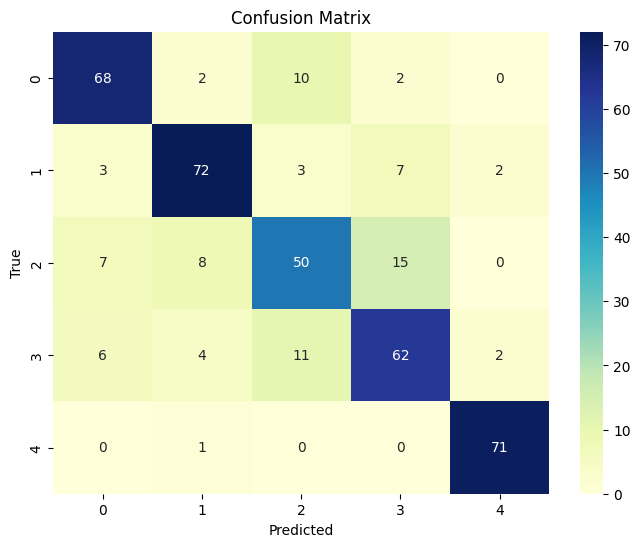

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='YlGnBu', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

📝 The confusion matrix visualizes the performance of the ensemble classifier on the validation dataset. Overall, the classifier performs well on most classes, with the highest number of correct predictions on classes 1 and 4. The classifier has some difficulty distinguishing between classes 2 and 3, as there are a considerable number of misclassifications between these two classes. The classifier also misclassifies some instances of class 0 as class 2. However, the performance is still reasonably good, and the classifier should provide useful predictions on the test dataset.

### Precision-Recall Curves

Compute predicted probabilities for each class:

In [ ]:
y_probs = ensemble.predict_proba(X_val)

Plot precision-recall curves:

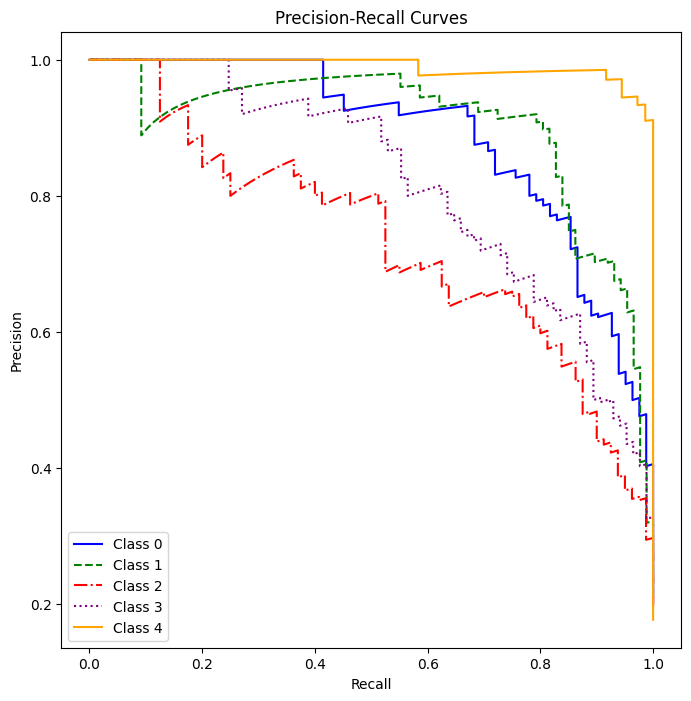

In [ ]:
# Define line styles and colors for better visualization
line_styles = ['-', '--', '-.', ':', '-']
colors = ['blue', 'green', 'red', 'purple', 'orange']

plt.figure(figsize=(8, 8))

# Iterate through each class and compute precision-recall curves
for idx, label in enumerate(np.unique(y_val)):
    precision, recall, _ = precision_recall_curve(y_val == label, y_probs[:, idx])
    plt.plot(recall, precision, linestyle=line_styles[idx % len(line_styles)], color=colors[idx % len(colors)], label=f'Class {label}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='best')
plt.savefig('precision_recall_curves.png')
plt.show()

📝 The precision-recall curves display the tradeoff between precision and recall for each class in a 1-vs.-rest setting. On the whole, the ensemble model is highly effective at predicting class 1 and class 4 with high precision and recall values. It shows moderate performance for class 0, while struggling to accurately predict class 2 and class 3, which may be due to their similarities with other classes or insufficient distinctive features in the dataset.